In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np 
from scipy.integrate import quad
from math import *
from astropy.io import fits
import glob
import pylab 
from numpy.linalg import inv
import pandas
from iminuit import Minuit, describe

In [2]:
# Physical constants
clight = 299792.458
H0 = 0.00007324 # Riess et al. 2016: H0 = 73.24 ± 1.74 km s−1 Mpc−1

# Baseline parameters from Ancillary_G10.FITRES
Npar = 5
omgM0 = 0.298     # = 0.298 +- 0.022
M_b0 = -19.3
alpha0 = 0.15424  #  alpha0         =    0.15424 +-  0.00553   
beta0 = 3.02371   #  beta0          =    3.02371 +-  0.06431   
gamma0 = 0.05271  #  gamma0         =    0.05271 +-  0.00917 
m_step = 10.13
tau = 0.001

In [3]:
# Comoving radial coordinate (c not included) corresponding to redshift z = c int_0^z dz/H(z)
# in LambdaCDM flat model
def intfun(z, omgM):
    return 1/sqrt(omgM*(1 + z)**3 + (1 - omgM))

In [4]:
# Luminosity Distance function
def fitfundL(zcmb, omgM):
    mu = []
    for i in range (len(zcmb)): 
        zz = zcmb[i]
        mu.append(dL_z(zz, zz, omgM)) 
    return mu 

In [5]:
# Luminosity Distance corresponding to a redshift z
def dL_z(zcmb, zhel, omgM):
    mu_zz = 5*log10((1 + zhel)*clight*(quad(intfun, 0, zcmb, args=(omgM))[0] / (10*H0)))
    return mu_zz

In [6]:
# Distance modulus for the observational data, delta_b calculated from delta_{mb,x1,c}
def muexp(mb, x1, color, M_b, alpha, beta, gamma, Mstell, delta_mb, delta_x1, delta_c):
    mu=[]
    for i in range(len(mb)):
        delta_M = gamma / (1 + np.exp(-(Mstell[i]-m_step)/tau))
        delta_b = delta_mb[i] - beta*delta_c[i] + alpha*delta_x1[i]
        mu.append(mb[i] - M_b + alpha*x1[i] - beta*color[i] + delta_M - delta_b)
    return mu

In [7]:
# Uncertainty on distance modulus for an observational data ???
def dmuexp(dmb, dx1, dcolor, alpha, beta):
    dmu=[]
    for i in range(len(dmb)):
        dmu.append(sqrt(dmb[i]**2+(alpha*dx1[i])**2+(beta*dcolor[i])**2))
    return dmu

In [8]:
def outliers(data_name):
    # Read LCs parameters for outlier supernovae
    filename_outliers = '../data/FITOPT000.FITRES'
    SNoutliers = pandas.read_csv(filename_outliers, comment='#', skiprows=11, header=0, delimiter=r"\s+")

    SNoutliers['wt_mb'] = 1./SNoutliers['mBERR']**2
    SNoutliers['wt_x1'] = 1./SNoutliers['x1ERR']**2
    SNoutliers['wt_c'] = 1./SNoutliers['cERR']**2

### weighted mean

    grouped = SNoutliers.groupby(['CID'], as_index=False)

    def wavg_mb(group):
        d = group['mB']
        w = group['wt_mb']
        return (d * w).sum() / w.sum()
    
    def wavg_x1(group):
        d = group['x1']
        w = group['wt_x1']
        return (d * w).sum() / w.sum()
    
    def wavg_c(group):
        d = group['c']
        w = group['wt_c']
        return (d * w).sum() / w.sum()

    df_mb = grouped.apply(wavg_mb)
    df_x1 = grouped.apply(wavg_x1)
    df_c = grouped.apply(wavg_c)

    for i in df_mb['CID']:
        try:
            ind = data_name.loc[data_name['CID'] == i].index[0]
            data_name.loc[ind,'mB'] = df_mb[(df_mb['CID'] == i)].values[0][1]
            data_name.loc[ind,'x1'] = df_x1[(df_x1['CID'] == i)].values[0][1]
            data_name.loc[ind,'c'] = df_c[(df_c['CID'] == i)].values[0][1]
        except Exception:
            continue
    return data_name

In [9]:
# Read covariance matrix 
# filecov = '../data/sys_full_long_G10.txt'
# # filecov = 'cov.txt'
# # filecov = '../data/sys_full_long.txt'

# SNcov = pandas.read_csv(filecov, comment='#', header=None)
# Ndim = int(SNcov[0][0])

# Cmat = np.zeros(Ndim*Ndim)
# for i in range (len(SNcov)):
#     if (i>0):
#         Cmat[i-1] = SNcov[0][i]
# Cmat = Cmat.reshape(Ndim,Ndim)

# for i in range(Ndim):
#     for j in range(Ndim):
#         if (i==j):
#             Cmat[i,j] = 0.15**2
#         else:
#             Cmat[i,j] = 0
# print('Cmat \n', Cmat)
# Cinv = inv(Cmat)

# # Cinv = Cmat


#cov matrix 

    
def mu_cov(zcmb, dmb, dx1, dcolor, delta_x1_x0, delta_c_x0, delta_x1_c, alpha, beta):
    # Read systematic covariance matrix 
    filecov = '../data/sys_full_long_G10.txt'
    SNcov = pandas.read_csv(filecov, comment='#', header=None)
    Ndim = int(SNcov[0][0])
    
    Cmu = np.zeros(Ndim*Ndim)
    for i in range (len(SNcov)):
        if (i>0):
            Cmu[i-1] = SNcov[0][i]
    Cmu = Cmu.reshape(Ndim,Ndim)
    
  #add diagonal term
    sig_mu2 = dmb**2 + (alpha*dx1)**2 + (beta*dcolor)**2 + 2*(alpha*delta_x1_x0-beta*delta_c_x0-alpha*beta*delta_x1_c)
    sig_mass = 0.001
    sig_z = (5 * 260 / 3e5) / (np.log(10.) * zcmb)
    sig_len = 0.055*zcmb
    sig_int = 0.09
    sig_bias = 0.0035  
           
    Cmu[np.diag_indices_from(Cmu)] += sig_mu2 + sig_mass**2 + sig_z**2+sig_len**2+sig_int**2+sig_bias**2
    return Cmu

In [10]:
# Definition of chi2 fucntion for minimization
class Chi2:

    def __init__(self, SNdata, zcmb, zhel, mb, dmb, x1, dx1, color, dcolor, Mstell, delta_mb, delta_c, delta_x1): # Construct method
        '''Attributes'''
        self.chi2tot = 0.
        self.zcmb = zcmb 
        self.zhel = zhel
        self.mb = mb
        self.dmb = dmb
        self.x1 = x1
        self.dx1 = dx1
        self.color = color
        self.dcolor = dcolor
        self.Mstell = Mstell
        self.delta_mb = delta_mb
        self.delta_c = delta_c
        self.delta_x1 = delta_x1
        self.delta_x1_x0 = delta_x1_x0
        self.delta_c_x0 = delta_c_x0
        self.delta_x1_c = delta_x1_c
        self.dL = np.zeros(shape=(len(zcmb))) 

#     def chi2(self, omgM, M_b, alpha, beta, gamma):
#         ''' Function to calculate the chi2 '''
#         global Cinv
#         mu_z = muexp(self.mb, self.x1, self.color, M_b, alpha, beta, gamma, self.Mstell, self.delta_mb, self.delta_x1, self.delta_c)
   
#         # Loop for matrix construction
#         for i in range(len(self.zcmb)):
#             zz = self.zcmb[i]
#             zzz = self.zhel[i]
#             self.dL[i] = dL_z(zz, zzz, omgM)
        
#         # Contruction of the chi2 by matrix product
#         result =  pylab.dot( (mu_z-self.dL), pylab.dot((Cinv), (mu_z-self.dL)))
#         self.chi2tot = result
#         return result
    
    
    def chi2(self, omgM, M_b, alpha, beta, gamma):
        ''' Function that calculate the chi2 '''
        global alpha_prev
        global beta_prev
        global Cinv
        if alpha != alpha_prev or beta != beta_prev:
            alpha_prev = alpha
            beta_prev = beta
            Cinv = inv(mu_cov(self.zcmb, self.dmb, self.dx1, self.dcolor, self.delta_x1_x0, self.delta_c_x0, self.delta_x1_c, alpha,beta))
        mu_z = muexp(self.mb, self.x1, self.color, M_b, alpha, beta, gamma, self.Mstell, self.delta_mb, self.delta_x1, self.delta_c)
        
        # Loop for matrix construction
        for i in range(len(self.zcmb)):
            zz = self.zcmb[i]
            zzz = self.zhel[i]
            self.dL[i] = dL_z(zz, zzz, omgM)
        
        # Contruction of the chi2 by matrix product
        result =  pylab.dot( (mu_z-self.dL), pylab.dot((Cinv), (mu_z-self.dL)))
        self.chi2tot = result
        return result

In [15]:
if __name__=='__main__':
    
    # Read Pantheon data
    filename_G10 = '../data/Ancillary_G10.FITRES'
    filename_C11 = '../data/Ancillary_C11.FITRES'
    
    data = pandas.read_csv(filename_G10, comment='#', skiprows=6, header=0, delimiter=r"\s+")  
    SNdata = outliers(data)

    sn_name = SNdata['CID']
    zcmb = SNdata['zCMB']
    zhel = SNdata['zHD']
    mb = SNdata['mB']
    dmb = SNdata['mBERR']
    x1 = SNdata['x1']
    dx1 = SNdata['x1ERR']
    color = SNdata['c']
    dcolor = SNdata['cERR']
    Mstell = SNdata['HOST_LOGMASS']
    dataset = SNdata['IDSAMPLE']
    delta_mb = SNdata['biasCor_mB']
    delta_c = SNdata['biasCor_c'] 
    delta_x1 = SNdata['biasCor_x1']  
    delta_x1_x0 = SNdata['COV_x1_x0'] 
    delta_c_x0 = SNdata['COV_c_x0']
    delta_x1_c = SNdata['COV_x1_c']
    
    # Global variables
    alpha_prev = alpha0
    beta_prev = beta0
    Cmat = mu_cov(zcmb, dmb, dx1, dcolor, delta_x1_x0, delta_c_x0, delta_x1_c, alpha0, beta0)
    Cinv = inv(Cmat)    
    
    # Perform SN fit
    ### added SNdata
    chi2function = Chi2(SNdata, zcmb, zhel, mb, dmb, x1, dx1, color, dcolor, Mstell, delta_mb, delta_c, delta_x1)
    m = Minuit(chi2function.chi2, omgM=omgM0, M_b=M_b0, alpha=alpha0, beta=beta0, gamma=gamma0,
               limit_omgM=(0.2,0.4), limit_M_b=(-20.,-18.), limit_alpha=(0.1,0.2), limit_beta=(2.,3.5), limit_gamma=(-0.1,0.1),
               fix_omgM=False, fix_M_b=False, fix_alpha=False, fix_beta=True, fix_gamma=True, 
               print_level=1)
    m.migrad()
    #m.hesse
    
    # Extract fitted parameters
    omgM, M_b, alpha, beta, gamma = list(m.args)
#     domgM, dM_b, dalpha, dbeta, dgamma = list(np.sqrt(np.diag(m.matrix())))
    domgM, dM_b, dalpha, dbeta, dgamma = 0, 0, 0, 0, 0
    chi2ndf = chi2function.chi2(omgM, M_b, alpha, beta, gamma) / (len(mb)-Npar)
    print(m.args)
    print('chi2ndf = ', chi2ndf)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: InitialParamWarning: errordef is not given. Default to 1.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


------------------------------------------------------------------
| FCN = 746.2                   |     Ncalls=102 (102 total)     |
| EDM = 7.98E-07 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
<ArgsView of Minuit at 7fdfd9f00f60>
  0.2990943474655638
  -19.19567387204147
  0.17013845343238115
  3.02371
  0.05271
chi2ndf =  0.7154245038438413


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


<IPython.core.display.Javascript object>


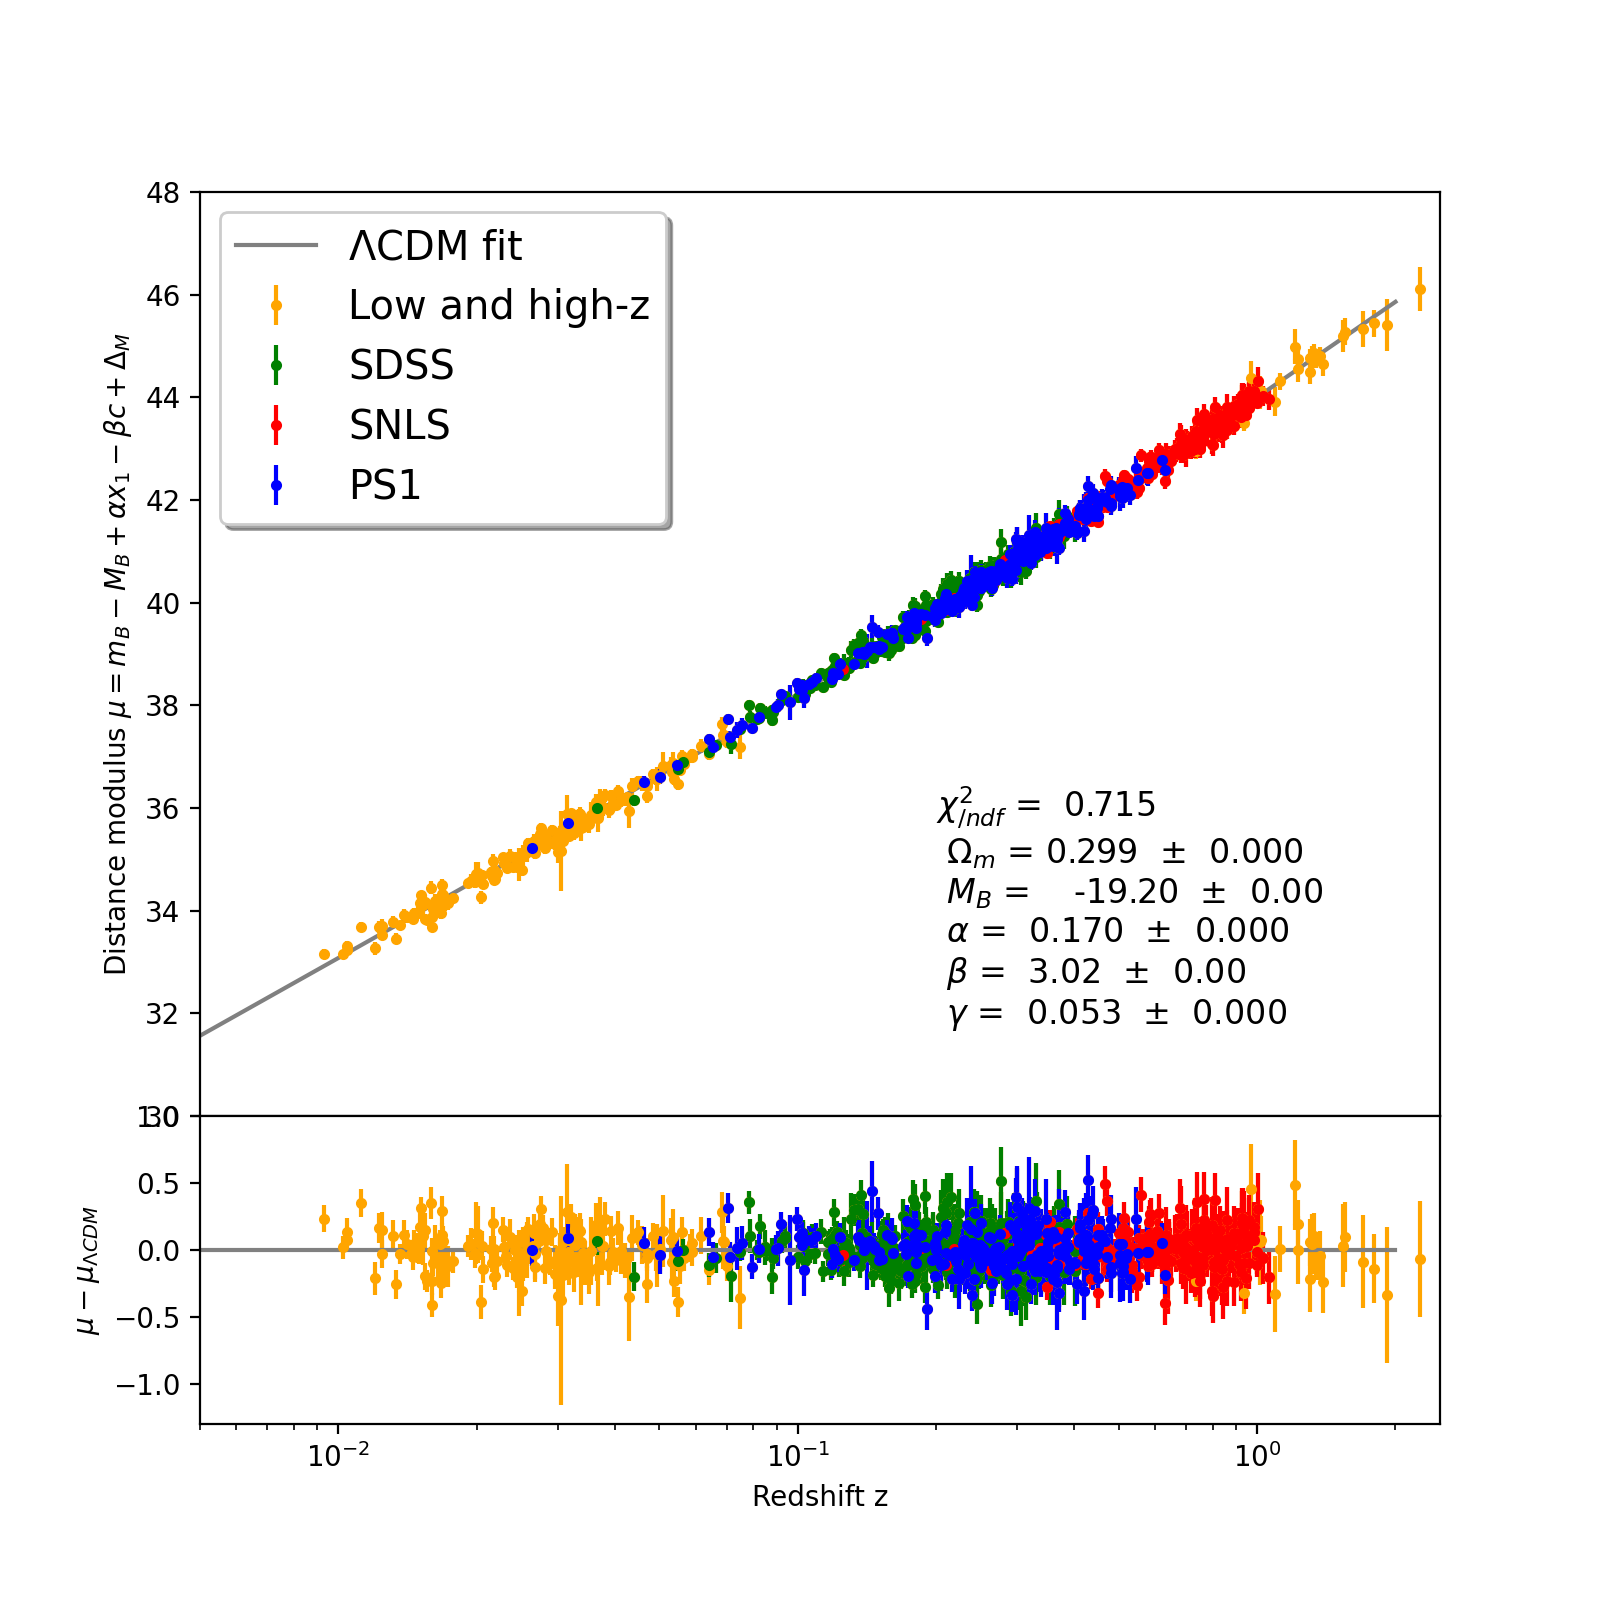

(-1.3, 1.0)

In [16]:
# Experimental distance modulus
SNdata['mu_exp'] = muexp(mb, x1, color, M_b, alpha, beta, gamma, Mstell, delta_mb, delta_x1, delta_c)
mu_exp = SNdata['mu_exp']
SNdata['dmu_exp'] = dmuexp(dmb, dx1, dcolor, alpha, beta)
dmu_exp = SNdata['dmu_exp']

# Theoretical distance modulus (LambdaCDM)
SNdata['mu_th'] = fitfundL(zcmb, omgM)
mu_th = SNdata['mu_th']

# Residual = experimental - theoretical
mu_res = []
dmu_res = []
for i in range(len(mu_exp)):
    mu_res.append(mu_exp[i] - mu_th[i])
    dmu_res.append(dmu_exp[i])
SNdata['res'] = mu_res
res = SNdata['res']
SNdata['dres'] = dmu_res
dres = SNdata['dres']
    
# Theoretical curve (LambdaCDM)
xfunc = np.linspace(0.001, 2, 1000)
yfunc = np.zeros(len(xfunc))
yfunc = fitfundL(xfunc, omgM)

x0 = np.linspace(0.001, 2, 1000)
y0 = np.zeros(len(x0))
 
str0 = '{0:10s} {1:2.3f} \n'.format(r'$\chi^2_{/ndf}$ = ', chi2ndf)
str1 = '{0:10s} {1:2.3f} {2:4s} {3:2.3f} \n'.format(r'$\Omega_m$ =', omgM, r' $\pm$ ', domgM)
str2 = '{0:10s} {1:4.2f} {2:4s} {3:4.2f} \n'.format(r'$M_B$ = ', M_b, r' $\pm$ ', dM_b)
str3 = '{0:10s} {1:2.3f} {2:4s} {3:2.3f} \n'.format(r'$\alpha$ = ', alpha, r' $\pm$ ', dalpha)
str4 = '{0:10s} {1:3.2f} {2:4s} {3:3.2f} \n'.format(r'$\beta$ = ', beta, r' $\pm$ ', dbeta)
str5 = '{0:10s} {1:2.3f} {2:4s} {3:2.3f} \n'.format(r'$\gamma$ = ', gamma, r' $\pm$ ', dgamma)
str_fit = '{} {} {} {} {} {}'.format(str0, str1, str2, str3, str4, str5)
#print(str_fit)
####

setNBandHST = dataset==0
setSDSS = dataset==2
setSNLS = dataset==3
setPS1 = dataset==1
setHST = dataset==4

fig = plt.figure(figsize=[8,8])
P1, P2 = fig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw=dict(height_ratios=[3,1]))
fig.subplots_adjust(hspace=0)
P1.errorbar(zcmb, mu_exp, yerr=dmu_exp, marker='.', color="orange", linestyle="None", 
            ecolor="orange", label='Low and high-z')
P1.errorbar(zcmb[setSDSS], mu_exp[setSDSS], yerr=dmu_exp[setSDSS], marker='.', color="green", linestyle="None", 
            ecolor="green", label='SDSS')
P1.errorbar(zcmb[setSNLS], mu_exp[setSNLS], yerr=dmu_exp[setSNLS], marker='.', color="red", linestyle="None", 
            ecolor="red", label='SNLS')
P1.errorbar(zcmb[setPS1], mu_exp[setPS1], yerr=dmu_exp[setPS1], marker='.', color="blue", linestyle="None", 
            ecolor="blue", label='PS1')

P1.plot(xfunc, yfunc, c="grey", label="$\Lambda$CDM fit")
P1.set_xlabel('Redshift z')
P1.set_ylabel(r'Distance modulus $\mu = m_B - M_B + \alpha x_1 - \beta c + \Delta_M$')  
P1.set_xscale('log')
P1.set_xlim(5e-3, 2.3)
P1.set_ylim(30, 48)
P1.text(0.2, 31, str_fit, fontsize=12)
P1.legend(loc='best', shadow=True, fontsize='x-large')

P2.errorbar(zcmb, res, yerr=dres, marker='.', color="orange", linestyle="None", 
            ecolor="orange")
P2.errorbar(zcmb[setSDSS], res[setSDSS], yerr=dres[setSDSS], marker='.', color="green", linestyle="None", 
            ecolor="green")
P2.errorbar(zcmb[setSNLS], res[setSNLS], yerr=dres[setSNLS], marker='.', color="red", linestyle="None", 
            ecolor="red")
P2.errorbar(zcmb[setPS1], res[setPS1], yerr=dres[setPS1], marker='.', color="blue", linestyle="None", 
            ecolor="blue")
P2.plot(x0, y0, c="grey", label="$\Lambda$CDM fit")


# P1.plot(zcmb, SNdata_G10['MU'], color="black", marker='+', linestyle="None", label='Pantheon data')
# P2.plot(zcmb, SNdata_G10['MURES'], marker='o', color="green", linestyle="None")



P2.set_xlabel('Redshift z')
P2.set_ylabel(r'$\mu - \mu_{\Lambda CDM}$')  
P2.set_xscale('log')
P2.set_xlim(5e-3, 2.5)
P2.set_ylim(-1.3, 1)

<IPython.core.display.Javascript object>


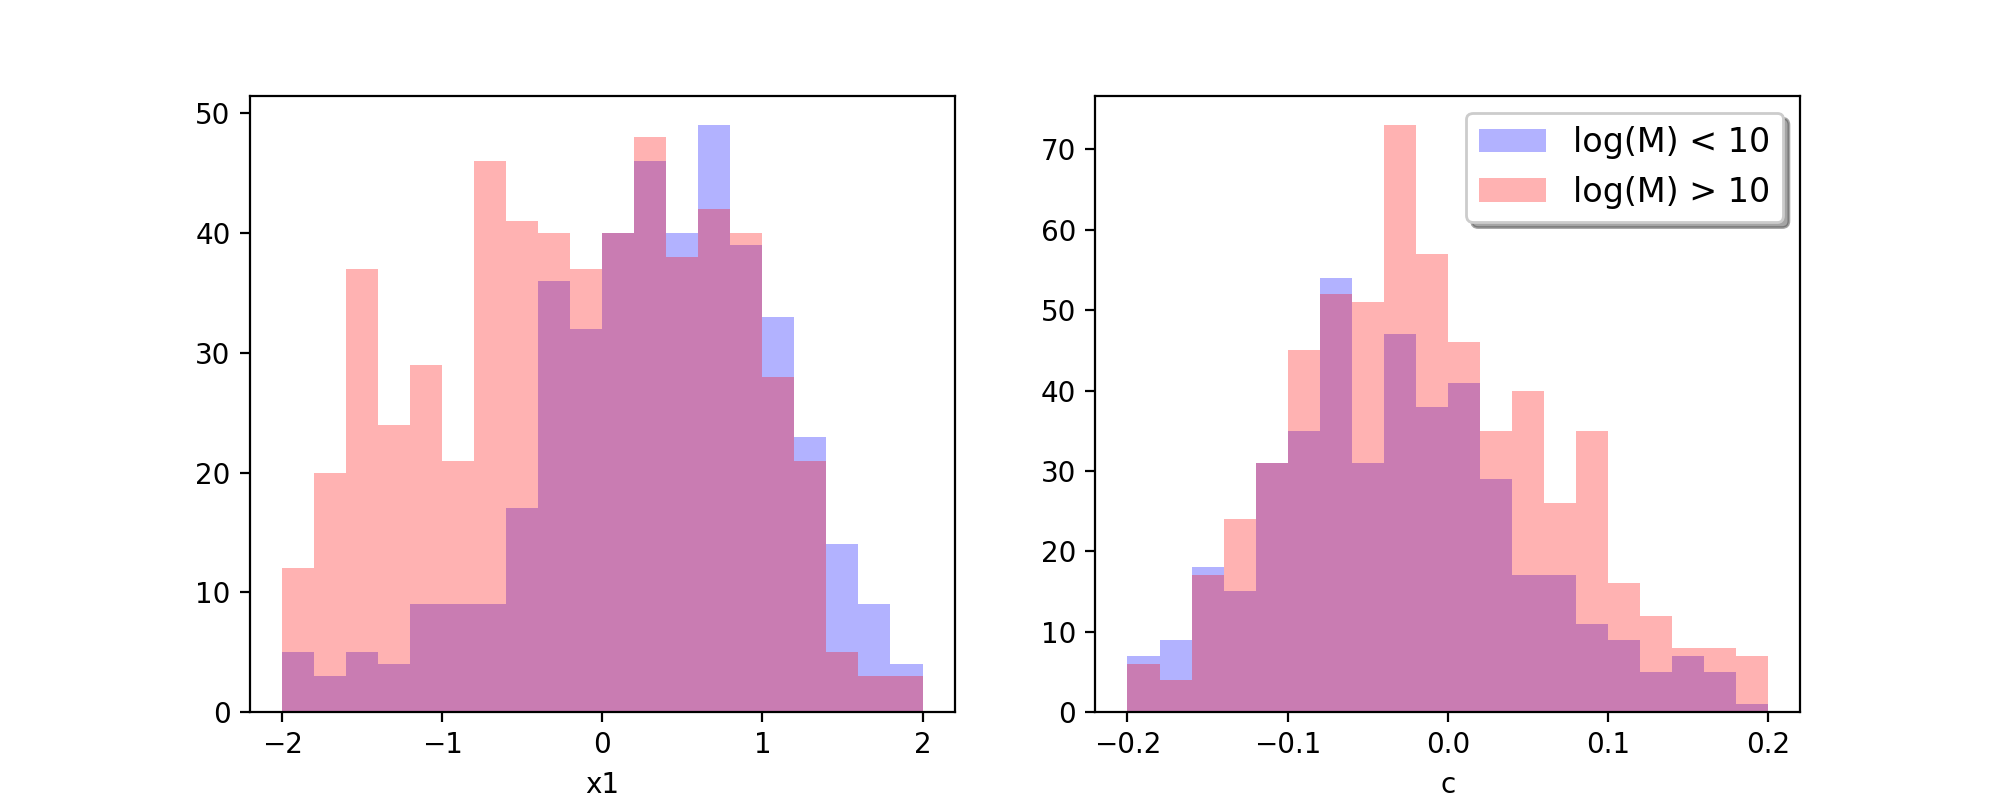

In [46]:
Mlow = Mstell<=10
Mhigh = Mstell>10

fig = plt.figure(figsize=[10,4])
ax  = fig.add_subplot(121)
ax.hist(x1[Mlow], 20, range=[-2,2], color='blue', alpha=0.3, label='log(M) < 10')
ax.hist(x1[Mhigh], 20, range=[-2,2], color='red', alpha=0.3, label='log(M) > 10')
ax.set_xlabel("x1")
ax  = fig.add_subplot(122)
ax.hist(color[Mlow], 20, range=[-0.2,0.2], color='blue', alpha=0.3, label='log(M) < 10')
ax.hist(color[Mhigh], 20, range=[-0.2,0.2], color='red', alpha=0.3, label='log(M) > 10')
ax.set_xlabel("c")
ax.legend(loc='best', shadow=True, fontsize='large')


In [8]:
    filename = '../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-g10.fitres'
    filename2 = '../data/Ancillary_G10.FITRES'